<a href="https://colab.research.google.com/github/samehaisaa/ML-Journey/blob/main/efficientnetb5_bone_marrow_classification_96_97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import time
import shutil
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
sns.set_style('darkgrid')
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

print ('modules loaded')

modules loaded


In [ ]:
def define_paths(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        fold_path = os.path.join(data_dir, fold)
        files = os.listdir(fold_path)
        for file in files:
            fpath = os.path.join(fold_path, file)
            filepaths.append(fpath)
            labels.append(fold)
    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def create_df(data_dir):
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)

    strat = df['labels']
    train_df, test_df = train_test_split(df,  train_size= 0.9, shuffle= True, random_state= 123, stratify= strat)

    return train_df, test_df

In [ ]:
def create_gens(train_df, test_df):
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    batch_size = 40
    ts_length = len(test_df)
    test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    def scalar(img):
        return img
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)
    return train_gen, test_gen

In [ ]:
def show_images(gen):
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes)
    images, labels = next(gen)        # get a batch size samples from the generator
    plt.figure(figsize= (20, 20))
    length = len(labels)              # length of batch size
    sample = min(length, 25)          # check if sample less than 25 images
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [ ]:
### Define a class for custom callback
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, base_model, patience, stop_patience, threshold, factor, batches, initial_epoch, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.base_model = base_model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to runn per epoch
        self.initial_epoch = initial_epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training
        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights

    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100 # get batch accuracy
        loss = logs.get('loss')
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') # prints over on the same line to show running batch count

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()

    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)     # get number of epoch with the lowest validation loss
    val_lowest = val_loss[index_loss]    # get the loss value of epoch with the lowest validation loss
    index_acc = np.argmax(val_acc)       # get number of epoch with the highest validation accuracy
    acc_highest = val_acc[index_acc]     # get the loss value of epoch with the highest validation accuracy

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]	       # create x-axis by epochs count
    loss_label = f'best epoch= {str(index_loss + 1)}'  # label of lowest val_loss
    acc_label = f'best epoch= {str(index_acc + 1)}'    # label of highest val_accuracy
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Testing loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Testing Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 159 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 17 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1174 validated image filenames belonging to 7 classes.
Found 132 validated image filenames belonging to 7 classes.


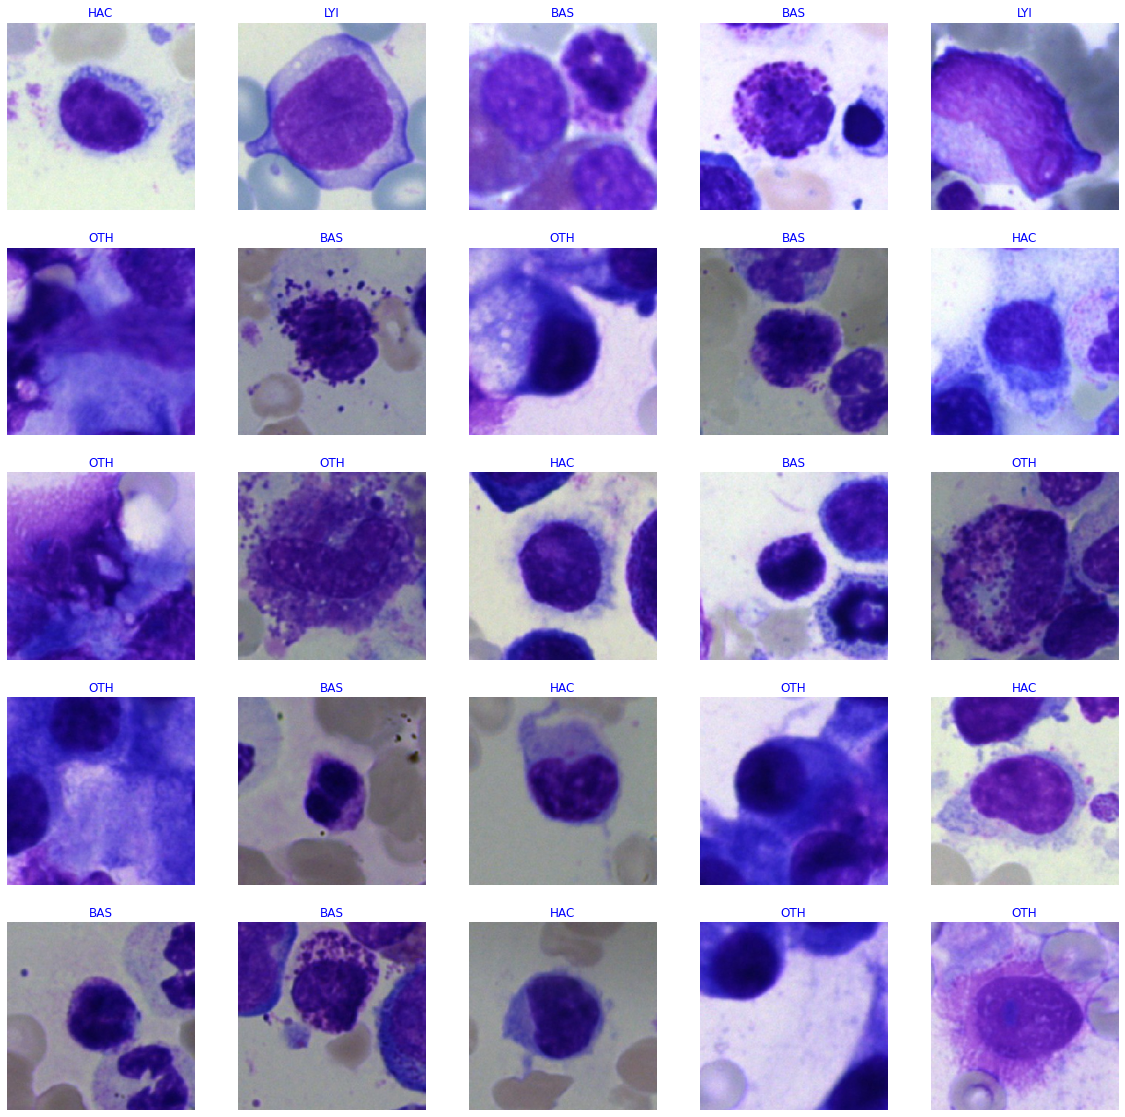

In [ ]:
# Get Dataframes
data_dir = '../input/bone-marrow-cell-classification/bone_marrow_cell_dataset'
train_df, test_df = create_df(data_dir)

# Get Generators
train_gen, test_gen = create_gens(train_df, test_df)

show_images(train_gen)

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model
base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

2022-12-01 19:34:17.180524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 19:34:17.280290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 19:34:17.281229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-01 19:34:17.282846: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

115277824/115263384 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb5 (Functional)  (None, 2048)              28513527  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 29,048,062
Trainable params: 28,871,223
Non-trainable params: 176,839
_________________________________________________________________


In [ ]:
batch_size = 40
epochs = 40
patience = 1 		# number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	# if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		# factor to reduce lr by
freeze = False 		# if true free weights of  the base model
ask_epoch = 5		# number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))

callbacks = [MyCallback(model= model, base_model= base_model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, initial_epoch= 0, epochs= epochs, ask_epoch= ask_epoch )]

In [ ]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= test_gen, validation_steps= None, shuffle= False,
                    initial_epoch= 0)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


2022-12-01 19:34:27.210276: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-01 19:34:49.907063: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-12-01 19:34:55.847547: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.44GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-12-01 19:34:55.882815: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.66GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-12-01 19:34:56.332217: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying t

 1 /40     9.099   58.603   9.74134  50.000   0.00100  0.00100  accuracy     0.00    61.49  
 2 /40     7.568   88.160   9.20403  48.485   0.00100  0.00100  accuracy    50.44    28.18  
 3 /40     6.713   93.952   7.65378  61.364   0.00100  0.00100  val_loss    16.84    28.06  
 4 /40     6.073   96.337   6.56603  71.970   0.00100  0.00100  val_loss    14.21    28.19  
 5 /40     5.493   96.763   6.06147  77.273   0.00100  0.00100  val_loss     7.68    28.55  
enter H to halt training or an integer for number of epochs to run then ask again


 10


 training will continue until epoch 15
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /40     4.968   97.530   5.30343  80.303   0.00100  0.00100  val_loss    12.51    28.42  
 7 /40     4.507   98.126   4.64323  86.364   0.00100  0.00100  val_loss    12.45    28.23  
 8 /40     4.088   98.637   4.20384  87.121   0.00100  0.00100  val_loss     9.46    28.42  
 9 /40     3.733   98.807   3.79582  88.636   0.00100  0.00100  val_loss     9.71    28.65  
10 /40     3.411   98.893   3.48592  90.909   0.00100  0.00100  val_loss     8.16    28.14  
11 /40     3.098   99.233   3.16315  91.667   0.00100  0.00100  val_loss     9.26    28.31  
12 /40     2.847   99.404   2.89630  92.424   0.00100  0.00100  val_loss     8.44    28.14  
13 /40     2.585   99.830   2.63022  92.424   0.00100  0.00100  val_loss     9.19    28.37  
14 /40     2.370   99.574   2.41078  93.182   0.00100  0.00100  val_loss     8.34    28.15  
15 /40     2.165   99.574   2.20

 5


 training will continue until epoch 20
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
16 /40     1.996   99.489   2.05951  90.909   0.00100  0.00100  val_loss     6.53    28.36  
17 /40     1.816   99.830   1.86065  93.182   0.00100  0.00100  val_loss     9.66    28.12  
18 /40     1.672   99.830   1.71379  93.939   0.00100  0.00100  val_loss     7.89    28.07  
19 /40     1.526   99.744   1.57825  93.939   0.00100  0.00100  val_loss     7.91    28.29  
20 /40     1.398   99.830   1.46084  93.939   0.00100  0.00100  val_loss     7.44    28.57  
enter H to halt training or an integer for number of epochs to run then ask again


 5


 training will continue until epoch 25
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
21 /40     1.277   99.830   1.35534  93.182   0.00100  0.00100  val_loss     7.22    28.25  
22 /40     1.174   100.000  1.24151  93.939   0.00100  0.00100  val_loss     8.40    28.40  
23 /40     1.082   99.915   1.15122  93.939   0.00100  0.00100  val_loss     7.27    27.93  
24 /40     0.990   99.744   1.05883  95.455   0.00100  0.00100  val_loss     8.03    28.36  
25 /40     0.919   99.659   0.98049  94.697   0.00100  0.00100  val_loss     7.40    28.09  
enter H to halt training or an integer for number of epochs to run then ask again


 5


 training will continue until epoch 30
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
26 /40     0.834   100.000  0.91608  94.697   0.00100  0.00100  val_loss     6.57    28.40  
27 /40     0.768   100.000  0.85717  93.939   0.00100  0.00100  val_loss     6.43    28.11  
28 /40     0.702   99.915   0.79567  95.455   0.00100  0.00100  val_loss     7.18    28.05  
29 /40     0.649   100.000  0.73727  95.455   0.00100  0.00100  val_loss     7.34    28.24  
30 /40     0.602   99.915   0.69103  96.212   0.00100  0.00100  val_loss     6.27    28.10  
enter H to halt training or an integer for number of epochs to run then ask again


 5


 training will continue until epoch 35
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
31 /40     0.555   100.000  0.64995  96.212   0.00100  0.00100  val_loss     5.94    28.32  
32 /40     0.513   100.000  0.61173  95.455   0.00100  0.00100  val_loss     5.88    28.30  
33 /40     0.479   100.000  0.57667  95.455   0.00100  0.00100  val_loss     5.73    27.99  
34 /40     0.451   99.830   0.53975  94.697   0.00100  0.00100  val_loss     6.40    28.46  
35 /40     0.414   99.744   0.51145  96.212   0.00100  0.00100  val_loss     5.24    28.92  
enter H to halt training or an integer for number of epochs to run then ask again


 5


 training will continue until epoch 40
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
36 /40     0.391   99.915   0.49057  95.455   0.00100  0.00100  val_loss     4.08    29.05  
37 /40     0.373   99.915   0.45234  96.212   0.00100  0.00100  val_loss     7.79    28.63  
38 /40     0.342   100.000  0.44368  96.212   0.00100  0.00100  val_loss     1.91    28.16  
39 /40     0.325   99.915   0.42838  96.970   0.00100  0.00100  val_loss     3.45    28.29  
40 /40     0.313   100.000  0.44454  96.212   0.00100  0.00050  val_loss    -3.77    28.10  
enter H to halt training or an integer for number of epochs to run then ask again


 h


training has been halted at epoch 40 due to user input
training elapsed time was 0.0 hours, 22.0 minutes, 40.11 seconds)


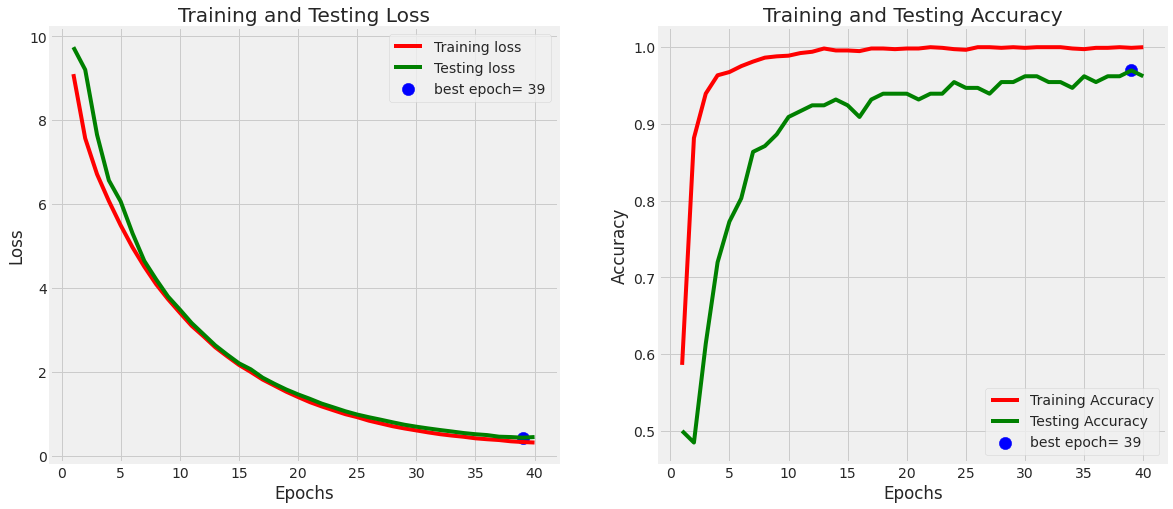

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size
train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

149/149 [==============================] - 4s 25ms/step - loss: 0.4284 - accuracy: 0.9697
Train Loss:  0.282977432012558
Train Accuracy:  1.0
--------------------
Test Loss:  0.42838436365127563
Test Accuracy:  0.9696969985961914


In [ ]:
model_name = 'EfficientNetB5'
subject = 'Bone-Marrow-Cells-Classification'
save_path = ''
acc = test_score[1] * 100

save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


model was saved as EfficientNetB5-Bone-Marrow-Cells-Classification-96.97.h5


In [ ]:
class_dict = train_gen.class_indices
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
subject = 'Stroke Prediction'
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Stroke Prediction-class_dict.csv
